In [1]:
import numpy as np
import torch

import sys
sys.path.insert(1,"../scripts")
from get_voxels import get_mol_voxels
from networks import Encoder, UNet3D, EncoderCNN, DecoderRNN
from utils import scale_model_input

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import itertools
from diffusers import DDPMScheduler


In [2]:
# Copyright (C) 2019 Computational Science Lab, UPF <http://www.compscience.org/>
# Copying and distribution is allowed under AGPLv3 license

vocab_list = ["pad", "start", "end",
    "C", "c", "N", "n", "S", "s", "P", "O", "o",
    "B", "F", "I",
    "Cl", "[nH]", "Br", # "X", "Y", "Z",
    "1", "2", "3", "4", "5", "6",
    "#", "=", "-", "(", ")"  # Misc
]

vocab_i2c_v1 = {i: x for i, x in enumerate(vocab_list)}
vocab_c2i_v1 = {vocab_i2c_v1[i]: i for i in vocab_i2c_v1}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

encoder = Encoder()
encoder.load_state_dict(torch.load("../models/state_dict_encoder.pt"))

net = UNet3D(in_channels=5, num_classes=5)
net.load_state_dict(torch.load("../models/state_dict_net.pt"))
# Initialize the DDPM scheduler
ddpm = DDPMScheduler(num_train_timesteps=1000)

#Load Encoding and Captioning Networks (from Ligdream)
encoderCNN = EncoderCNN(5)
encoderCNN.load_state_dict(torch.load("../models/encoder-210000.pkl",map_location="cpu"))
decoder = DecoderRNN(512, 1024, 29, 1)
decoder.load_state_dict(torch.load("../models/decoder-210000.pkl", map_location='cpu'))
use_cuda = True

encoder.to(device)
net.to(device)

Using device: cuda


UNet3D(
  (a_block1): Conv3DBlock(
    (conv1): Conv3d(5, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (a_block2): Conv3DBlock(
    (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, 

# Generate from Random Noise, unconditional

Puts random noise through the unet.

Gets prediction > Adds prediction to noise with mix factor > repeats for n_steps

Iteratively denoises initial blur

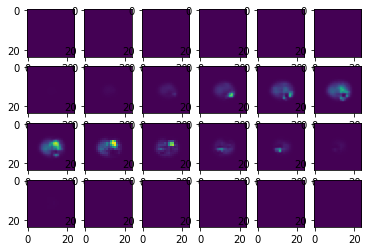

In [4]:
n_steps = 50
x = torch.rand(1,5,24,24,24).to(device) # Start from random
# x = input[0]
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

torch.save(pred.cpu(), "predicted_shape.pkl")

# pred -= pred.min(1, keepdim=True)[0]
# pred /= pred.max(1, keepdim=True)[0]

try:
    pred = pred.cpu().detach().numpy()
except:
    print("Already on cpu")


fields = [pred[0][0][i] for i in range(24)]

combined_data = np.array(fields)
#Get the min and max of all your data
_min, _max = np.amin(combined_data), np.amax(combined_data)

fig, axs = plt.subplots(4,6)

j = 0

for i in range(24):
    if i < 6:
        axs[0,i].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)
    if i>= 6 and i < 12:
        axs[1,i-6].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)
    if i>= 12 and i < 18:
        axs[2,i-12].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)
    if i>= 18:
        axs[3,i-18].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)

## Visualise Pharmacophore encoder performance

/home/chris/miniconda3/envs/ligdream/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



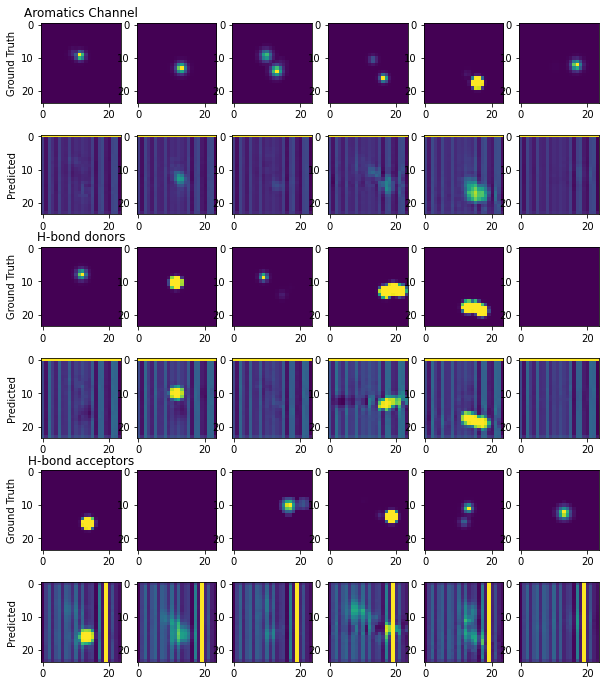

In [5]:
origs = []
pred_y = []
smiles = ["CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl",
        "CC1C(C(C)C)C2=C(C=C(C)C(C(C)=O)=C2)C1(C)C",
        "CC1=CC2=C(C(=CN2CC3=C(C(=NC=N3)N(C)C)C)C(=O)NCCO)N=C1",
        "COC(=O)NC(=O)C1=C(SC=C1)NC(=O)C2=CC=C(C=C2)C(=O)N3CCCCC3",
        "C1C2CC3CC1CC(C2)C3NC(=O)C4=CC(=CN4)C5=C(N=C(C=C5)F)F",
        "CCCN1C=NC2=C1C=CC(=C2)NCC3=C(C=C(C=C3)Cl)Cl "]
for i in range(len(smiles)):
    x_ref, y = get_mol_voxels(smiles[i])
    pharm_pred = encoder(torch.tensor(x_ref).reshape(-1,5,24,24,24).to(device))
    origs.append(y.cpu().detach().numpy())
    pred_y.append(pharm_pred.cpu().detach().numpy())


# Plot comparisons of individual slices

figs, axs = plt.subplots(nrows=6,ncols=6,figsize=(10,12))

layer = 15

for ax,i in zip(axs[0],range(6)):
    ax.imshow(origs[i][0][layer])
axs[0,0].set_ylabel("Ground Truth")
axs[0,0].set_title("Aromatics Channel")
for ax,i in zip(axs[1],range(6)):
    ax.imshow(pred_y[i][0][0][layer])
axs[1,0].set_ylabel("Predicted")

for ax,i in zip(axs[2],range(6)):
    ax.imshow(origs[i][1][layer])
axs[2,0].set_ylabel("Ground Truth")
axs[2,0].set_title("H-bond donors")
for ax,i in zip(axs[3],range(6)):
    ax.imshow(pred_y[i][0][1][layer])
axs[3,0].set_ylabel("Predicted")

for ax,i in zip(axs[4],range(6)):
    ax.imshow(origs[i][2][layer])
axs[4,0].set_ylabel("Ground Truth")
axs[4,0].set_title("H-bond acceptors")
for ax,i in zip(axs[5],range(6)):
    ax.imshow(pred_y[i][0][2][layer])
axs[5,0].set_ylabel("Predicted")

plt.show()

Plot from random noise with conditioning

In [4]:
loss_fn = torch.nn.MSELoss

In [6]:

def generate_molecule(smiles, gen_num, guidance_loss_scale = 10000, timesteps=150, vox2vox=False, get_vox = True):

    '''Input smiles, uses denoising u-net to generate representation then decodes.
    If vox2vox enabled then puts in a noised version of the original voxel'''

    x_ref, y = get_mol_voxels(smiles)

    ddpm.set_timesteps(timesteps)
    if vox2vox:
        x = x_ref.reshape(-1,5,24,24,24).to(device)
        x = torch.cat([x]*gen_num)
        noise = torch.rand(x.shape).to(device)
        x = x*0.9+noise*0.1
    else:
        x = torch.randn(gen_num, 5, 24,24,24).to(device)


    y = y.reshape(-1,3,24,24,24).to(device)
    y= torch.cat([y]*gen_num)

    for i, t in enumerate(ddpm.timesteps):

        # Prepare the model input
        model_input = scale_model_input(x, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = net(model_input)

        # Set x.requires_grad to True
        x = x.detach().requires_grad_(True)

        # Get the predicted x0
        x0 = ddpm.step(noise_pred, t, x)["prev_sample"] #.pred_original_sample

        # Calculate loss

        pred_pharm = encoder(x0)
        loss = torch.nn.functional.mse_loss(y,pred_pharm)*guidance_loss_scale*gen_num

        if i % 10 == 0:
            print(i, loss)

        # Get gradient

        cond_grad = -torch.autograd.grad(loss, x)[0]

        # Modify x based on this gradient
        x = x.detach() + cond_grad

        # Now step with scheduler
        x = ddpm.step(noise_pred, t, x)["prev_sample"]

    noise_pred = noise_pred.cpu()

    smiles_gen = []
    for predict in noise_pred:
        embedding = encoderCNN(predict.reshape(-1,5,24,24,24))

        captions = decoder.sample_prob(embedding)
        captions = [captions]

        gen_smiles = []
        for sample in captions:
            csmile = ""
            for xchar in sample[0:]:
                if xchar == 1:
                    continue
                if xchar == 2:
                    break
                csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
            gen_smiles.append(csmile)

        smiles_gen = smiles_gen+gen_smiles

    smiles_gen = np.unique(np.array(smiles_gen))
    if get_vox:
        return noise_pred.cpu(), smiles_gen
    else:
        return smiles_gen

In [7]:
input_smiles = "O=C(N)C1=C(C2=CC(CCC(O)=O)=CC=C2)C=C(CC3=CC=CC=C3)C=C1"

In [32]:
# pred, smiles_gen = generate_molecule(input_smiles,64,timesteps=50,guidance_loss_scale=10000, vox2vox=False)

smiles_gen = []
while len(smiles_gen) < 512:
    pred, smiles_g = generate_molecule(input_smiles,64,timesteps=50,guidance_loss_scale=10000)
    smiles_gen = smiles_gen + list(smiles_g)
    print(len(smiles_gen))

0 tensor(107852.1641, device='cuda:0', grad_fn=<MulBackward0>)
10 tensor(80141.1172, device='cuda:0', grad_fn=<MulBackward0>)
20 tensor(72232.8125, device='cuda:0', grad_fn=<MulBackward0>)
30 tensor(68430.9453, device='cuda:0', grad_fn=<MulBackward0>)
40 tensor(65870.7500, device='cuda:0', grad_fn=<MulBackward0>)
64
0 tensor(107994.3047, device='cuda:0', grad_fn=<MulBackward0>)
10 tensor(80313.9297, device='cuda:0', grad_fn=<MulBackward0>)
20 tensor(72397.1875, device='cuda:0', grad_fn=<MulBackward0>)
30 tensor(68572.2812, device='cuda:0', grad_fn=<MulBackward0>)
40 tensor(65979.8750, device='cuda:0', grad_fn=<MulBackward0>)
127
0 tensor(108082.6094, device='cuda:0', grad_fn=<MulBackward0>)
10 tensor(80183.9609, device='cuda:0', grad_fn=<MulBackward0>)
20 tensor(72256.7031, device='cuda:0', grad_fn=<MulBackward0>)
30 tensor(68425.9062, device='cuda:0', grad_fn=<MulBackward0>)
40 tensor(65836.2188, device='cuda:0', grad_fn=<MulBackward0>)
191
0 tensor(107766.4531, device='cuda:0', grad_

In [31]:
#Plot representations - ref + generated. Plotted as 3d isosurfaces

rep_no = 25
channel = 3 # Channels 0) Hydrophobic (alkyl, greasy etc.), 1) Aromatic 2) H-donors 3) H-acceptors 4) occupancy (VdW radii of all atoms)

test = get_mol_voxels(input_smiles)[0].numpy().reshape(-1,5,24,24,24)

X,Y,Z = [list(np.arange(d)) for d in (24,24,24) ]
voxels = list(itertools.product(X,Y,Z))
isoval = [test[0][channel][i][j][k] for i,j,k in voxels]
voxels = np.array(voxels)
X, Y, Z = [voxels[:,i] for i in range(3)]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value = isoval,
    isomin=0.1,
    isomax=1.0,
    opacity=0.05, # needs to be small to see through all surfaces
    surface_count=21, # needs to be a large number for good volume rendering
    ))
fig.show()

X,Y,Z = [list(np.arange(d)) for d in (24,24,24) ]
voxels = list(itertools.product(X,Y,Z))
isoval = [pred[rep_no][channel][i][j][k] for i,j,k in voxels]
X, Y, Z = [np.array(voxels)[:,i] for i in range(3)]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value = isoval,
    isomin=0.1,
    isomax=1.0,
    opacity=0.05, # needs to be small to see through all surfaces
    surface_count=64, # needs to be a large number for good volume rendering
    ))
fig.show()

## Examine Results

RDKit ERROR: [09:46:58] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [09:46:58] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 25
RDKit ERROR: 
RDKit ERROR: [09:46:58] Can't kekulize mol.  Unkekulized atoms: 1 2 19 20 21 24 25
RDKit ERROR: 
RDKit ERROR: [09:46:58] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit ERROR: 
RDKit ERROR: [09:46:58] Can't kekulize mol.  Unkekulized atoms: 18 19 20
RDKit ERROR: 
RDKit ERROR: [09:46:58] Can't kekulize mol.  Unkekulized atoms: 9 10 11 19 20
RDKit ERROR: 
RDKit ERROR: [09:46:58] SMILES Parse Error: ring closure 3 duplicates bond between atom 13 and atom 14 for input: 'COc1cccc(CC(C)c2nc(C3(N3CCNC3=O)CCCC3)no2)c1'
RDKit ERROR: [09:46:58] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [09:46:58] SMILES Parse Error: extra close parentheses while parsing: CC1CC(=O)NCCN1C(=O)c1ccc(CSc2nccn3C)o2)c1
RDKit ERROR: [09:46:58] SMILES Parse Error: Failed parsing SMILES 'CC1CC(=O

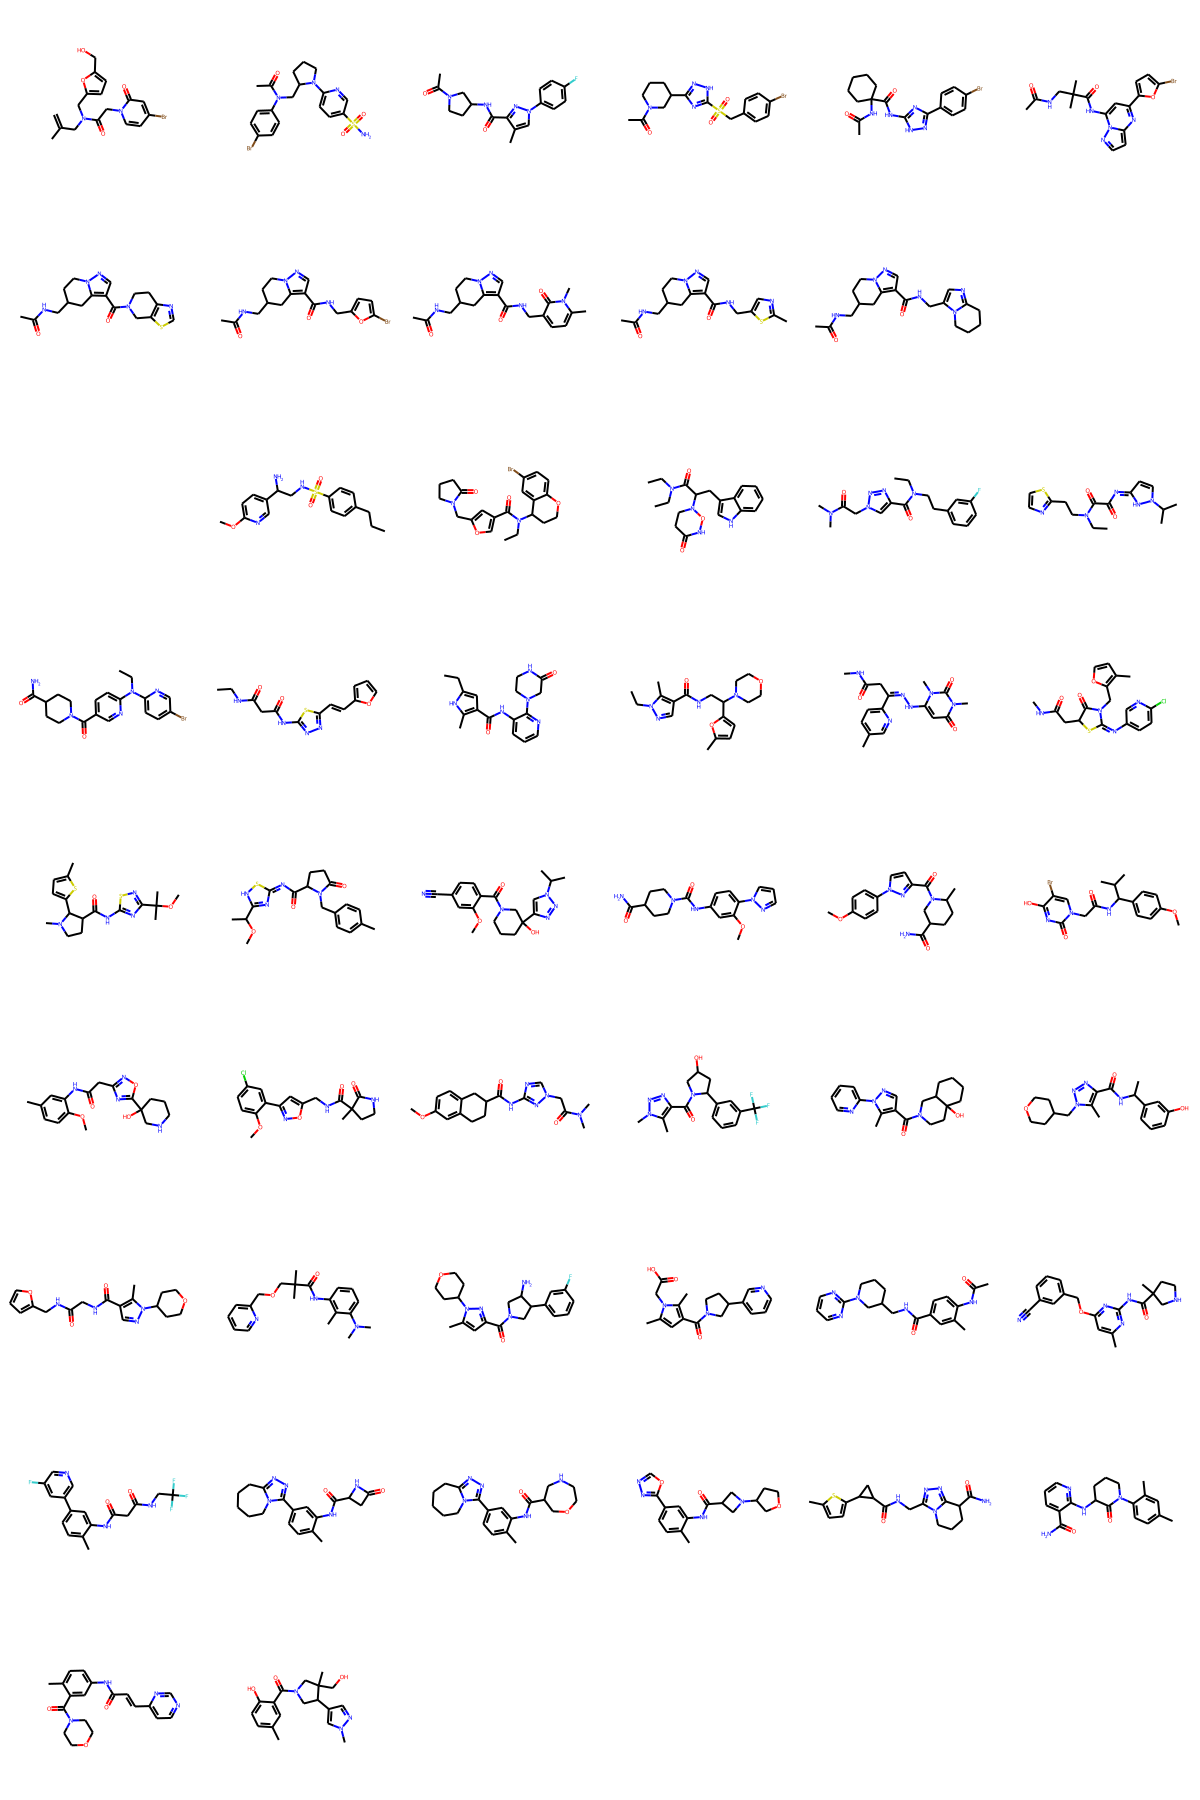

In [33]:
from rdkit import Chem

mols = [Chem.MolFromSmiles(x) for x in smiles_gen]
Chem.Draw.MolsToGridImage(mols, molsPerRow=6)

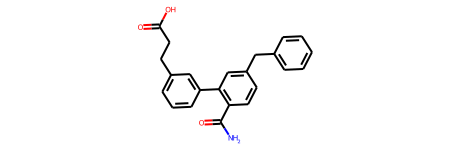

In [34]:
ref_mol = Chem.MolFromSmiles(input_smiles)
ref_mol

In [35]:
import pandas as pd

predictions = pd.DataFrame(smiles_gen, columns=["SMILES"])
predictions["mol"] = [Chem.MolFromSmiles(x) for x  in predictions.SMILES]
predictions.dropna(inplace=True)
predictions["sp3"]=[Chem.rdMolDescriptors.CalcFractionCSP3(mol) for mol in predictions.mol]
predictions["n_rings"]=[Chem.rdMolDescriptors.CalcNumRings(mol) for mol in predictions.mol]
predictions["h_don"] = [Chem.rdMolDescriptors.CalcNumLipinskiHBD(mol) for mol in predictions.mol]
predictions["h_acc"] = [Chem.rdMolDescriptors.CalcNumLipinskiHBA(mol) for mol in predictions.mol]
similarity = []

ref_fp = Chem.AllChem.GetMorganFingerprintAsBitVect(ref_mol,2,nBits=2048)
for mol in predictions.mol:
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048)
    similarity.append(Chem.AllChem.DataStructs.FingerprintSimilarity(ref_fp,fp))

predictions["similarity"] = similarity

RDKit ERROR: [09:47:08] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [09:47:08] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 25
RDKit ERROR: 
RDKit ERROR: [09:47:08] Can't kekulize mol.  Unkekulized atoms: 1 2 19 20 21 24 25
RDKit ERROR: 
RDKit ERROR: [09:47:08] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit ERROR: 
RDKit ERROR: [09:47:08] Can't kekulize mol.  Unkekulized atoms: 18 19 20
RDKit ERROR: 
RDKit ERROR: [09:47:08] Can't kekulize mol.  Unkekulized atoms: 9 10 11 19 20
RDKit ERROR: 
RDKit ERROR: [09:47:08] SMILES Parse Error: ring closure 3 duplicates bond between atom 13 and atom 14 for input: 'COc1cccc(CC(C)c2nc(C3(N3CCNC3=O)CCCC3)no2)c1'
RDKit ERROR: [09:47:08] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [09:47:08] SMILES Parse Error: extra close parentheses while parsing: CC1CC(=O)NCCN1C(=O)c1ccc(CSc2nccn3C)o2)c1
RDKit ERROR: [09:47:08] SMILES Parse Error: Failed parsing SMILES 'CC1CC(=O

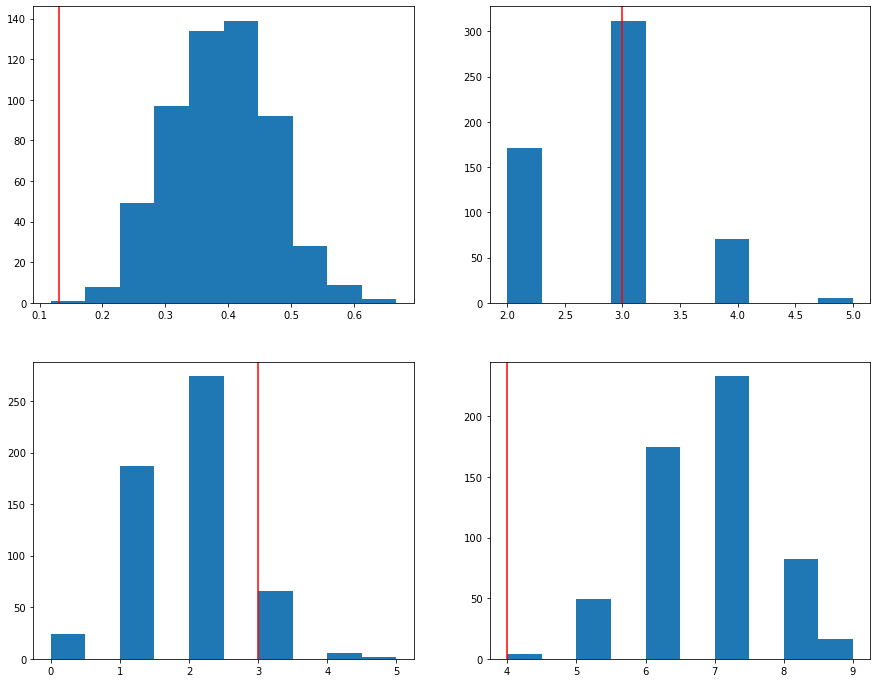

In [36]:
fig, axs = plt.subplots(2,2,figsize=(15,12))

axs[0,0].hist(predictions.sp3)
axs[0,0].axvline(Chem.rdMolDescriptors.CalcFractionCSP3(ref_mol),0,1, color="red")
axs[0,1].hist(predictions.n_rings)
axs[0,1].axvline(Chem.rdMolDescriptors.CalcNumRings(ref_mol),0,1, color="red")
axs[1,0].hist(predictions.h_don)
axs[1,0].axvline(Chem.rdMolDescriptors.CalcNumLipinskiHBD(ref_mol),0,1, color="red")
axs[1,1].hist(predictions.h_acc)
axs[1,1].axvline(Chem.rdMolDescriptors.CalcNumLipinskiHBA(ref_mol),0,1, color="red")


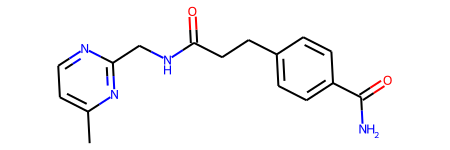

In [37]:
predictions.sort_values("similarity", ascending=False).reset_index(drop=True).mol[0]

In [39]:
predictions.drop("mol", axis=1).to_csv("../reports/AZD_generated_tr200000.csv")